In [1]:
# Create Spark Session

from pyspark.sql import SparkSession

spark = SparkSession \
        .builder \
        .appName("Read Voter File Data") \
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/18 05:58:00 INFO SparkEnv: Registering MapOutputTracker
24/03/18 05:58:00 INFO SparkEnv: Registering BlockManagerMaster
24/03/18 05:58:01 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/03/18 05:58:01 INFO SparkEnv: Registering OutputCommitCoordinator


In [2]:
# global variables 
class_bucket_name = "winter-2024-voter-file"
local_bucket_name = "pstat135-final-project1"
class_folder_name = "VM2Uniform"  

In [3]:
""" Use these functions to [read/write] [parquet files/data frames] [from/to] Google Cloud"""

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, count

def read_parquet_file(spark_session, file_path):
    """
    Reads a Parquet file and returns a Spark DataFrame.
    
    Parameters:
    spark_session (SparkSession): An active SparkSession.
    file_path (str): The path to the Parquet file.

    Returns:
    DataFrame: A Spark DataFrame containing the data from the Parquet file.
    """

    # Read the Parquet file
    df = (
        spark_session.read
        .format("parquet")
        .option("header", "true")
        .option("inferSchema", "true")
        .load(file_path)
    )

    return df


def write_df_to_gcs_parquet(spark_session, df, bucket_name, file_path):
    """
    Writes a Spark DataFrame to a Google Cloud Storage bucket as a Parquet file.
    
    Parameters:
    spark_session (SparkSession): An active SparkSession.
    df (DataFrame): The Spark DataFrame to write.
    bucket_name (str): The name of the Google Cloud Storage bucket.
    file_path (str): The file path within the bucket where the Parquet file will be saved.
    """
    
    # Define the GCS path
    gcs_path = f"gs://{bucket_name}/data_cleaned/{file_path}"

    # Write the DataFrame as a Parquet file to GCS
    df.write.parquet(gcs_path, mode='overwrite')
    

def list_content(bucket_name):
    """
    Lists all the blobs in the bucket.
    
    Parameters: 
    bucket_name (str): The name of the Google Cloud Storage bucket. 
    """
    storage_client = storage.Client()
    content = storage_client.list_blobs(bucket_name)
    
    for file in content:
        print(file.name)

def column_missing_percentage1(df):
    """
    Calculate the percentage of missing values for each column in the DataFrame.
    
    Parameters:
    df (DataFrame): A Spark DataFrame.
    
    Returns:
    DataFrame: A new DataFrame with two columns: 'Column_Name' and 'Missing_Percentage'.
    """
    missing_percentage_data = []
    total_count = df.count()
    
    for c in df.columns:
        missing_count = df.filter(col(c).isNull() | (col(c) == '')).count()
        missing_percentage = (missing_count / total_count) * 100
        missing_percentage_data.append((c, missing_percentage))
    
    missing_percentage_df = spark.createDataFrame(missing_percentage_data, ["Column_Name", "Missing_Percentage"])
    return missing_percentage_df

In [4]:
df_final = read_parquet_file(spark, "gs://pstat135-final-project1/data_cleaned/dataset_young_demographic")

In [5]:
from pyspark.sql.functions import when, col, regexp_replace
from pyspark.ml.feature import StringIndexer

def clean_dataset(df):
    """
    Clean our dataset by applying the following: 
        1) Convert 'CommercialData_EstHomeValue' from string to int data type
        2) Extract state from `LALVOTERID`
        3) Convert `Voters_Gender` into a 0/1 depending on Gender
        4) Fill missing values in 'General_2020', 'PresidentialPrimary_2020', 'Primary_2020'
    
    Parameters:
    df (DataFrame): A Spark DataFrame.
    
    Returns:
    DataFrame: A new DataFrame with the necessary columns. 
    """
    df_num = df.withColumn("CommercialData_EstHomeValue_in_Dollars", regexp_replace("CommercialData_EstHomeValue", "\\$", "").cast("int"))    
    df_with_state = df_num.withColumn("State", col("LALVOTERID").substr(4, 2))
    cleaned_df = df_with_state.filter(df_with_state.Voters_Gender.isNotNull())
    converted_df = cleaned_df.withColumn("Gender", when(col("Voters_Gender") == "M", 1).otherwise(0))
    converted_df = converted_df.filter(converted_df.CommercialData_EstimatedHHIncome.isNotNull())
    
    indexer = StringIndexer(inputCol="CommercialData_EstimatedHHIncome", outputCol="CommercialData_EstimatedHHIncome_ctg", handleInvalid="skip")

    # Fit and transform the DataFrame
    model = indexer.fit(converted_df)
    df_categorical = model.transform(converted_df)
    
    df_a = df_categorical.fillna({'General_2020': 'N'})
    df_b = df_a.fillna({'PresidentialPrimary_2020': 'N'})
    df_c = df_b.fillna({'Primary_2020': 'N'})
    
    df_final = df_c.drop("Voters_StateVoterID")
    return df_final

In [6]:
df_final = clean_dataset(df_final)

In [7]:
df_final.printSchema()

root
 |-- Voters_FirstName: string (nullable = true)
 |-- Voters_LastName: string (nullable = true)
 |-- LALVOTERID: string (nullable = true)
 |-- Voters_Age: string (nullable = true)
 |-- Voters_Gender: string (nullable = true)
 |-- General_2020: string (nullable = false)
 |-- Primary_2020: string (nullable = false)
 |-- Ethnic_Description: string (nullable = true)
 |-- PresidentialPrimary_2020: string (nullable = false)
 |-- EthnicGroups_EthnicGroup1Desc: string (nullable = true)
 |-- CommercialData_Education: string (nullable = true)
 |-- CommercialData_EstHomeValue: string (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = true)
 |-- CommercialData_EstHomeValue_in_Dollars: integer (nullable = true)
 |-- State: string (nullable = true)
 |-- Gender: integer (nullable = false)
 |-- CommercialData_EstimatedHHIncome_ctg: double (nullable = false)



In [8]:
# Logistic Regression

from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

df_model = df_final.select('Voters_Age','Voters_Gender', 'General_2020', 'EthnicGroups_EthnicGroup1Desc', 
                           'CommercialData_EstHomeValue_in_Dollars', 'CommercialData_EstimatedHHIncome', 
                            'State')

df_model_cleaned = df_model.dropna()
df_model_cleaned = df_model_cleaned.withColumn("Voters_Age_int", col("Voters_Age").cast("int"))
df_model_cleaned = df_model_cleaned.drop("Voters_Age")

df = df_model_cleaned.sample(False, 0.2)

df_model_cleaned.printSchema()

root
 |-- Voters_Gender: string (nullable = true)
 |-- General_2020: string (nullable = false)
 |-- EthnicGroups_EthnicGroup1Desc: string (nullable = true)
 |-- CommercialData_EstHomeValue_in_Dollars: integer (nullable = true)
 |-- CommercialData_EstimatedHHIncome: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Voters_Age_int: integer (nullable = true)



In [9]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import when

# Convert General_2020 to binary
df = df.withColumn("label", when(df.General_2020 == "Y", 1).otherwise(0))

# StringIndexer for categorical variables 
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ['Voters_Gender', 'State', 
                                                                                             'EthnicGroups_EthnicGroup1Desc', 
                                                                                             'CommercialData_EstimatedHHIncome']]
# OneHotEncoding for categorical variables
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+"_vec") for indexer in indexers]

# Assemble all feature columns (including numerical features) into a single vector
assemblerInputs = [encoder.getOutputCol() for encoder in encoders] + ['CommercialData_EstHomeValue_in_Dollars', 'Voters_Age_int']
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

# Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])

# Split the data into training and test sets (70% training, 30% test)
train_data, test_data = df.randomSplit([0.7, 0.3])

# Fit the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

In [10]:
training_summary = model.stages[-1].summary

# Obtain various metrics
accuracy = training_summary.accuracy
precision = training_summary.precisionByLabel
recall = training_summary.recallByLabel
fMeasure = training_summary.fMeasureByLabel()
roc_auc = training_summary.areaUnderROC

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {fMeasure}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.6358461184308521
Precision: [0.569812218439168, 0.6505533369096581]
Recall: [0.26641780150570377, 0.8716280968268616]
F1 Score: [0.36307741862139525, 0.7450367667972498]
ROC AUC: 0.6398454281870353


In [16]:
from pyspark.ml.classification import LogisticRegressionModel

# Assuming 'pipeline_model' is the fitted pipeline model
# Extract LogisticRegressionModel from the pipeline
lr_model = model.stages[-1]

# Ensure the extracted stage is a LogisticRegressionModel
if isinstance(lr_model, LogisticRegressionModel):
    coefficients = lr_model.coefficients
    # Now you can use the coefficients for your chart
    # ...
else:
    print("The last stage is not a LogisticRegressionModel.")


In [1]:
import statsmodels.api as sm
import pandas as pd

# Assuming `df` is your DataFrame, `X` are your features, and `y` is your target variable.

# Add a constant to the predictor variable set to account for the intercept
X_with_const = sm.add_constant(df[X])

# Fit the logistic regression model
logit_model = sm.Logit(df[y], X_with_const).fit()

# Display the summary of the logistic regression model
print(logit_model.summary())


NameError: name 'df' is not defined

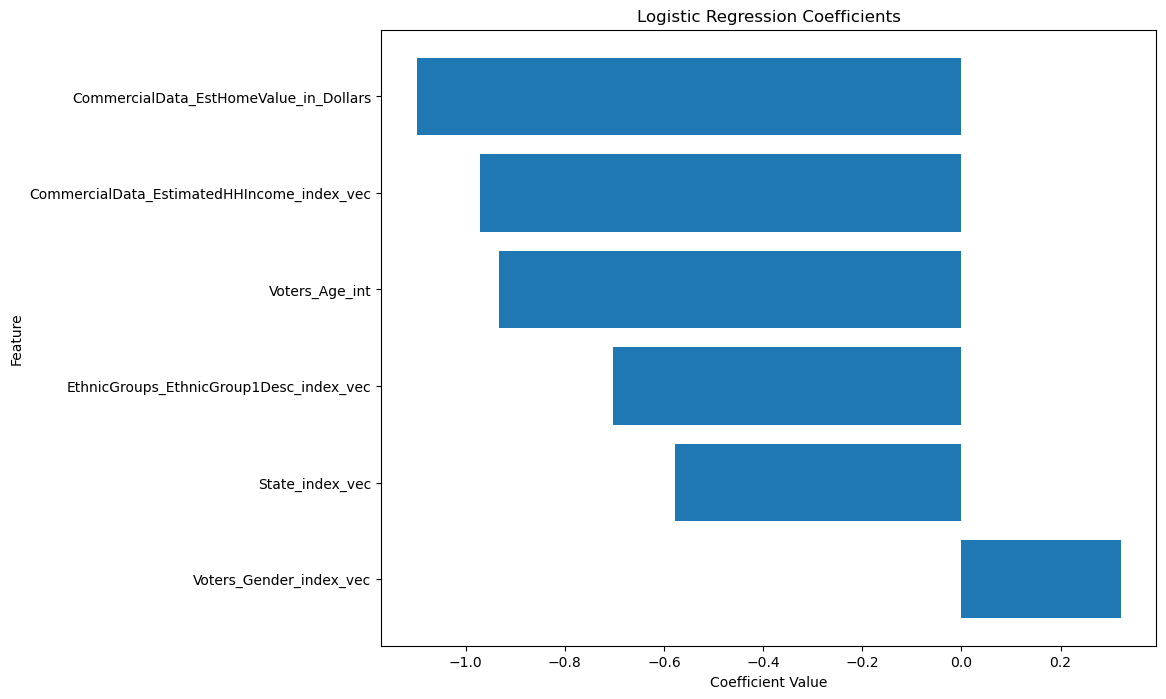

In [17]:
import matplotlib.pyplot as plt

# Get feature names from the VectorAssembler
# Assuming 'assembler' is your VectorAssembler used in the pipeline
feature_names = assembler.getInputCols()

# Sort by the absolute values of coefficients
sorted_coefficients = sorted(zip(coefficients.toArray(), feature_names), key=lambda x: abs(x[0]), reverse=True)

# Unpack the sorted coefficients and feature names
sorted_coefficients, sorted_features = zip(*sorted_coefficients)

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_features)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis to have the largest at the top
plt.show()
